## Import libraries

In [1]:
# Import some required libraries. Some libraries will be imported later if needed.
import numpy as np 
import pandas as pd 
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

## load dataset

In [2]:
from sklearn.datasets import load_files
training_directory = r'C:/Users/polit/OneDrive/Desktop/fruits-360/Ours/Training'

def load_images(image_path):
    data = load_files(image_path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_images(training_directory)


print('Successfully loaded !')
print('Number of training images : ' , x_train.shape[0])


Successfully loaded !
Number of training images :  396


In [3]:
train_categories = []
train_samples = []
for i in os.listdir(training_directory):
    train_categories.append(i)
    train_samples.append(len(os.listdir("../fruits-360/Ours/Training/"+ i)))
index = np.arange(len(target_labels))

In [4]:
# Check image classes
print (train_categories)

['Apple Golden', 'Apple Granny Smith', 'Apple Red', 'Avocado', 'Banana', 'Blueberry', 'Cocos', 'Grape pink', 'Grape White', 'Kiwi', 'Lemon', 'Mango', 'Melon Piel de Sapo', 'Orange', 'Papaya', 'Pineapple', 'Pomegranate', 'Strawberry', 'Watermelon']


In [5]:
# Chek number of images in each class
print('Number of images in each catagories ' ,train_samples)


Number of images in each catagories  [39, 24, 33, 12, 18, 45, 18, 18, 18, 27, 15, 16, 11, 32, 12, 12, 13, 17, 16]


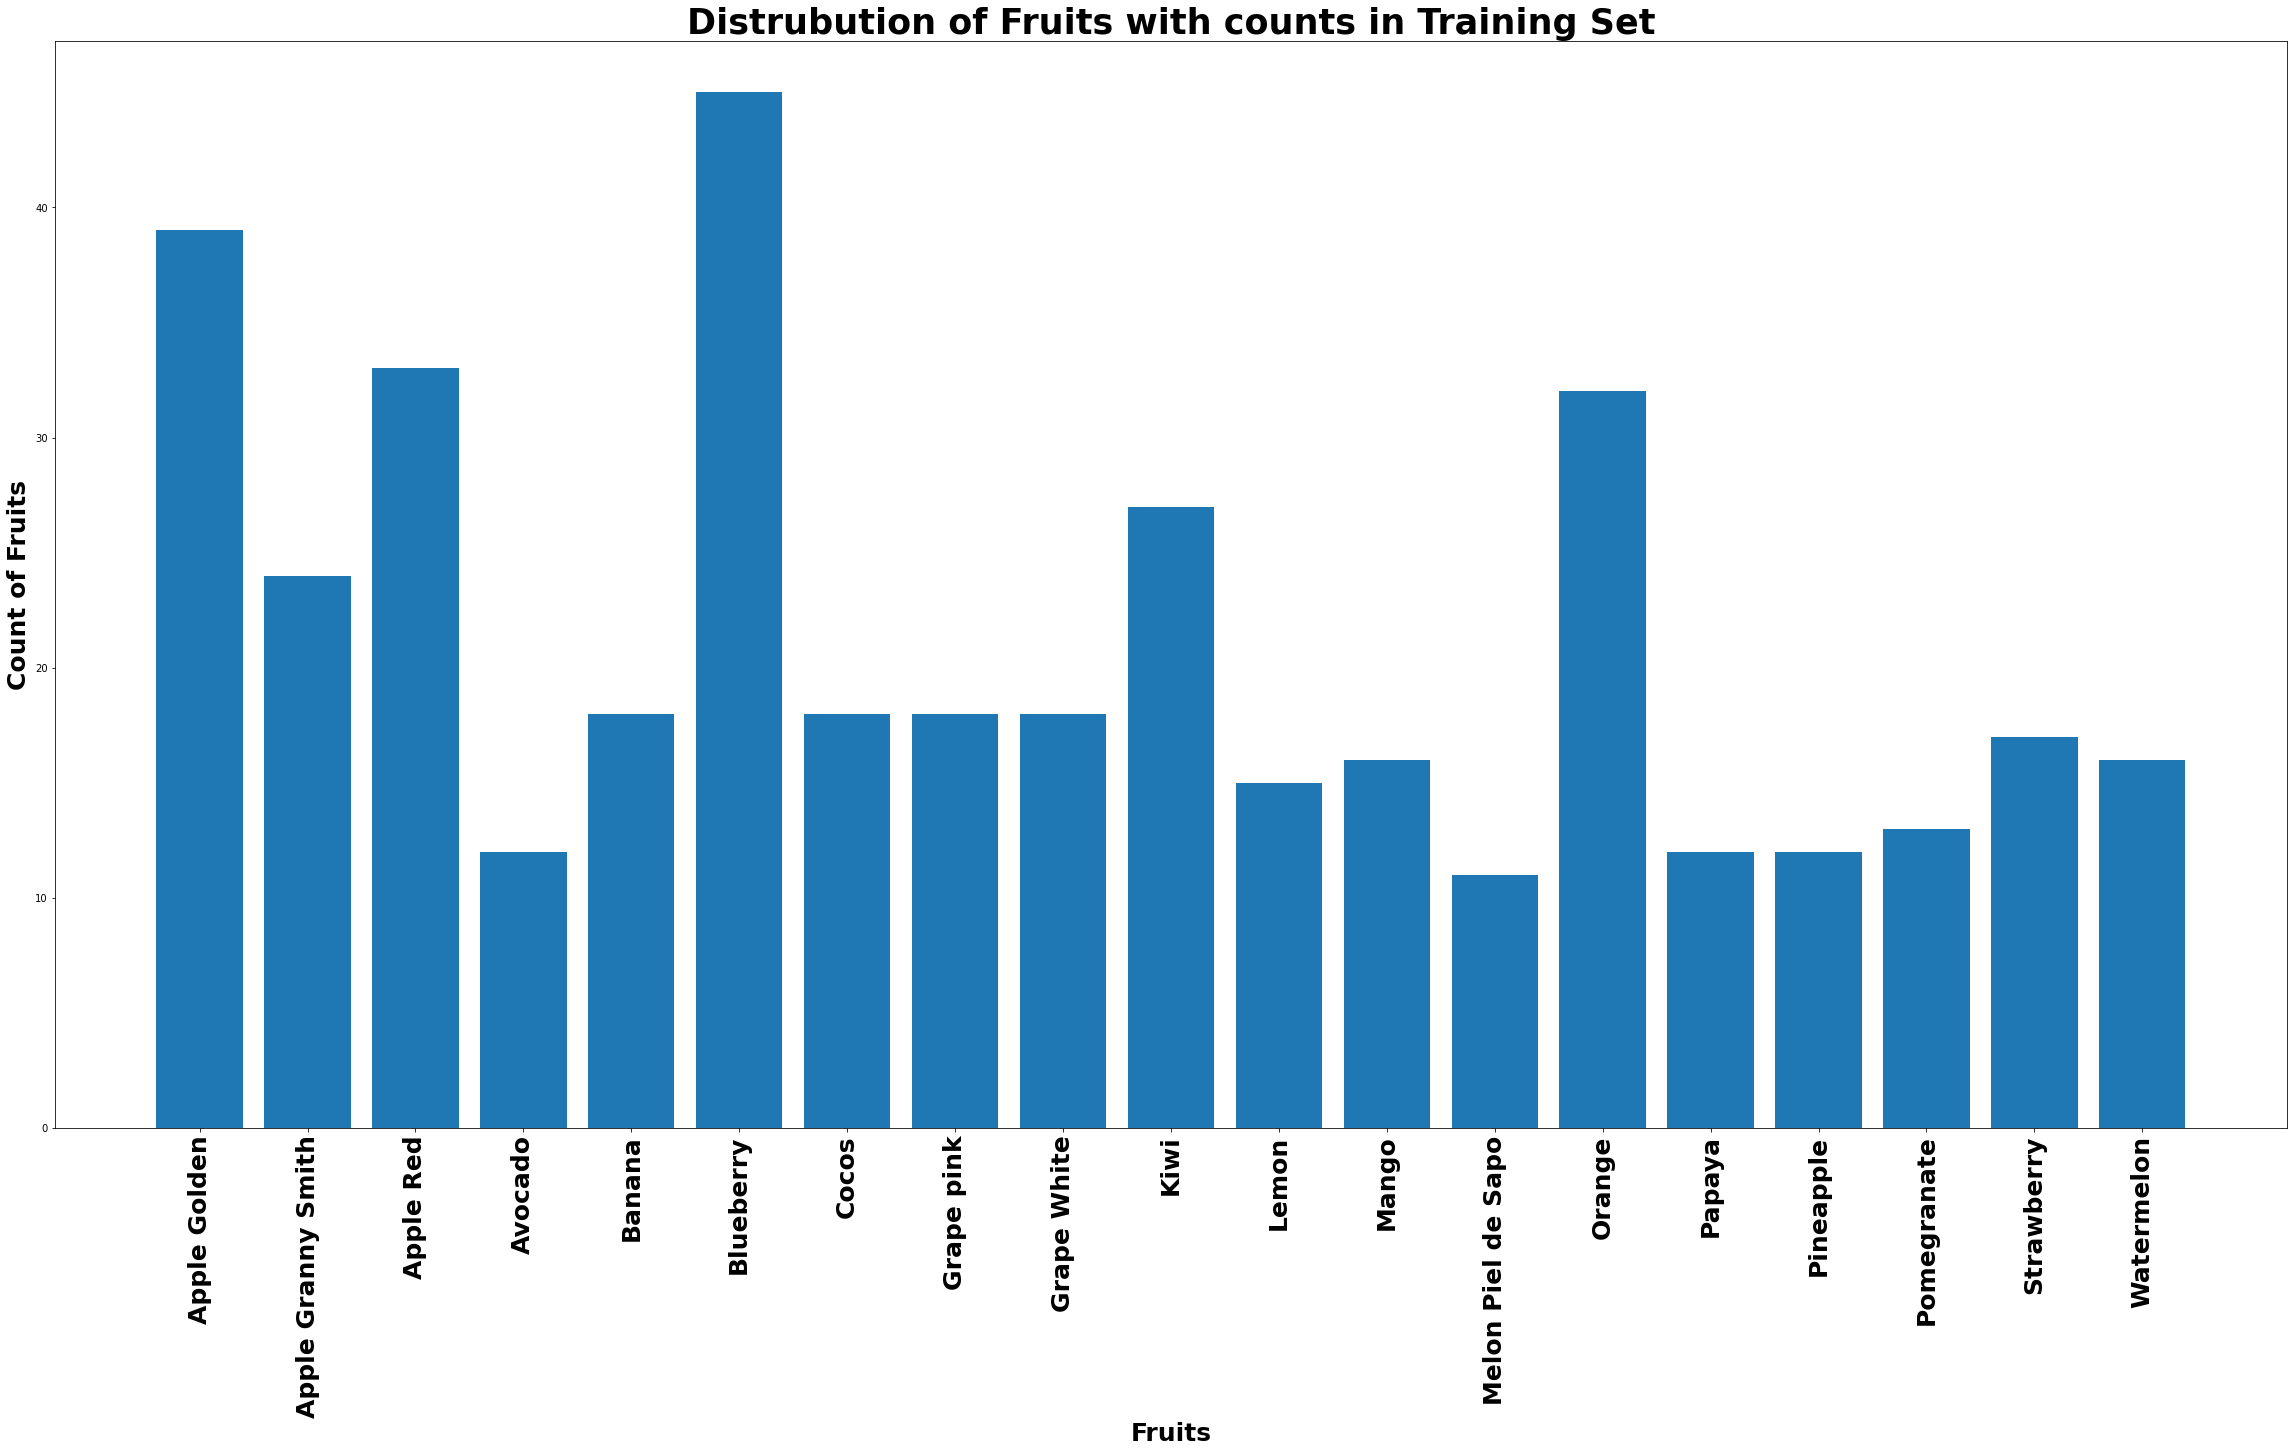

In [6]:
# Let us draw number of images in each catagories. 
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
index = np.arange(len(target_labels))
plt.bar(index, train_samples)
plt.xlabel('Fruits', fontsize=25, weight = 'bold')
plt.ylabel('Count of Fruits', fontsize=25, weight = 'bold')
plt.xticks(index, train_categories, fontsize=25, rotation=90, weight = 'bold')
plt.title('Distrubution of Fruits with counts in Training Set', fontsize=35, weight = 'bold')
plt.show()

In [7]:
# split dataset in to training and testing. 40 % will be on testing and 60 % will be on training.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, stratify=y_train)

## check no of classes

In [8]:
no_of_classes = len(np.unique(y_train))
no_of_classes

19

## Convert class vector (integers from 0 to nb_classes) to binary class matrix

In [9]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test= np_utils.to_categorical(y_test,no_of_classes)

## number of training data

In [10]:
x_train.shape,y_train.shape

((237,), (237, 19))

## number of test data

In [11]:
x_test.shape,y_test.shape

((159,), (159, 19))

 ## convert images to numpy array

In [12]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Shape of Training set: ',x_train.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Shape of Test set : ',x_test.shape)

print('Shape of one training image ',x_train[0].shape)

Shape of Training set:  (237, 100, 100, 3)
Shape of Test set :  (159, 100, 100, 3)
Shape of one training image  (100, 100, 3)


## Scale features  between 0.0 and 1.0.

In [13]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

## Import keras and define model

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout,Activation,BatchNormalization,MaxPool2D
from keras.optimizers import Adamax, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from tensorflow.keras.optimizers import Adadelta
from keras.regularizers import l2
model = Sequential()

model.add(Conv2D(filters = 16, strides=(1, 1),kernel_size = (3,3),input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(19,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        1

## Compile the model

In [15]:
# optimizer=Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer='Adamax',
              metrics=['accuracy', tf.keras.metrics.Precision()])

learned_weights = ModelCheckpoint(filepath = 'C:/Users/polit/OneDrive/Desktop/fruits-360/fruits_360_original.hdf5', verbose = 2, save_best_only = True)


history = model.fit(x_train,y_train,
        batch_size = 20,
        epochs=100,
        validation_split=0.2,           
        callbacks = [learned_weights],
        verbose=2, shuffle=True)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.89536, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 2s - loss: 3.5406 - accuracy: 0.2011 - precision: 0.2857 - val_loss: 2.8954 - val_accuracy: 0.0625 - val_precision: 0.0000e+00
Epoch 2/100

Epoch 00002: val_loss improved from 2.89536 to 2.84042, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 1s - loss: 1.4464 - accuracy: 0.5873 - precision: 0.8023 - val_loss: 2.8404 - val_accuracy: 0.1250 - val_precision: 0.0000e+00
Epoch 3/100

Epoch 00003: val_loss improved from 2.84042 to 2.72184, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 1s - loss: 0.7759 - accuracy: 0.7672 - precision: 0.8741 - val_loss: 2.7218 - val_accuracy: 0.3958 - val_precision: 0.0000e+00
Epoch 4/100

Epoch 00004: val_loss improved from 2.72184 to 2.67721, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_o

Epoch 30/100

Epoch 00030: val_loss improved from 0.93272 to 0.86018, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 2s - loss: 0.0183 - accuracy: 0.9947 - precision: 1.0000 - val_loss: 0.8602 - val_accuracy: 0.9375 - val_precision: 1.0000
Epoch 31/100

Epoch 00031: val_loss improved from 0.86018 to 0.79783, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 2s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.7978 - val_accuracy: 0.9167 - val_precision: 1.0000
Epoch 32/100

Epoch 00032: val_loss improved from 0.79783 to 0.76952, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_original.hdf5
10/10 - 2s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.7695 - val_accuracy: 0.9167 - val_precision: 1.0000
Epoch 33/100

Epoch 00033: val_loss improved from 0.76952 to 0.73133, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\fruits_360_origi

Epoch 63/100

Epoch 00063: val_loss did not improve from 0.30476
10/10 - 2s - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.3196 - val_accuracy: 0.9167 - val_precision: 0.9565
Epoch 64/100

Epoch 00064: val_loss did not improve from 0.30476
10/10 - 2s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.9167 - val_precision: 0.9565
Epoch 65/100

Epoch 00065: val_loss did not improve from 0.30476
10/10 - 2s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.3256 - val_accuracy: 0.9375 - val_precision: 0.9565
Epoch 66/100

Epoch 00066: val_loss did not improve from 0.30476
10/10 - 2s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.3210 - val_accuracy: 0.9167 - val_precision: 0.9565
Epoch 67/100

Epoch 00067: val_loss did not improve from 0.30476
10/10 - 2s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - val_loss: 0.3324 - val_accuracy: 0.9167 - val_precision: 0.9565
Epoch 68/100

Epoch 

## Load the saved model

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('C:/Users/polit/OneDrive/Desktop/fruits-360/fruits_360_original.hdf5')

## Evaluate the model using test data. Test data was not used for training and validation

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)

# score contains the metrics passed in the compile method. Here: loss, accuracy, and precision
print(model.metrics_names)
print(score)

['loss', 'accuracy', 'precision']
[0.27440983057022095, 0.9433962106704712, 0.9548386931419373]


## Import CSV file that contains nutrition values and predict the nutrition value of the fruit.

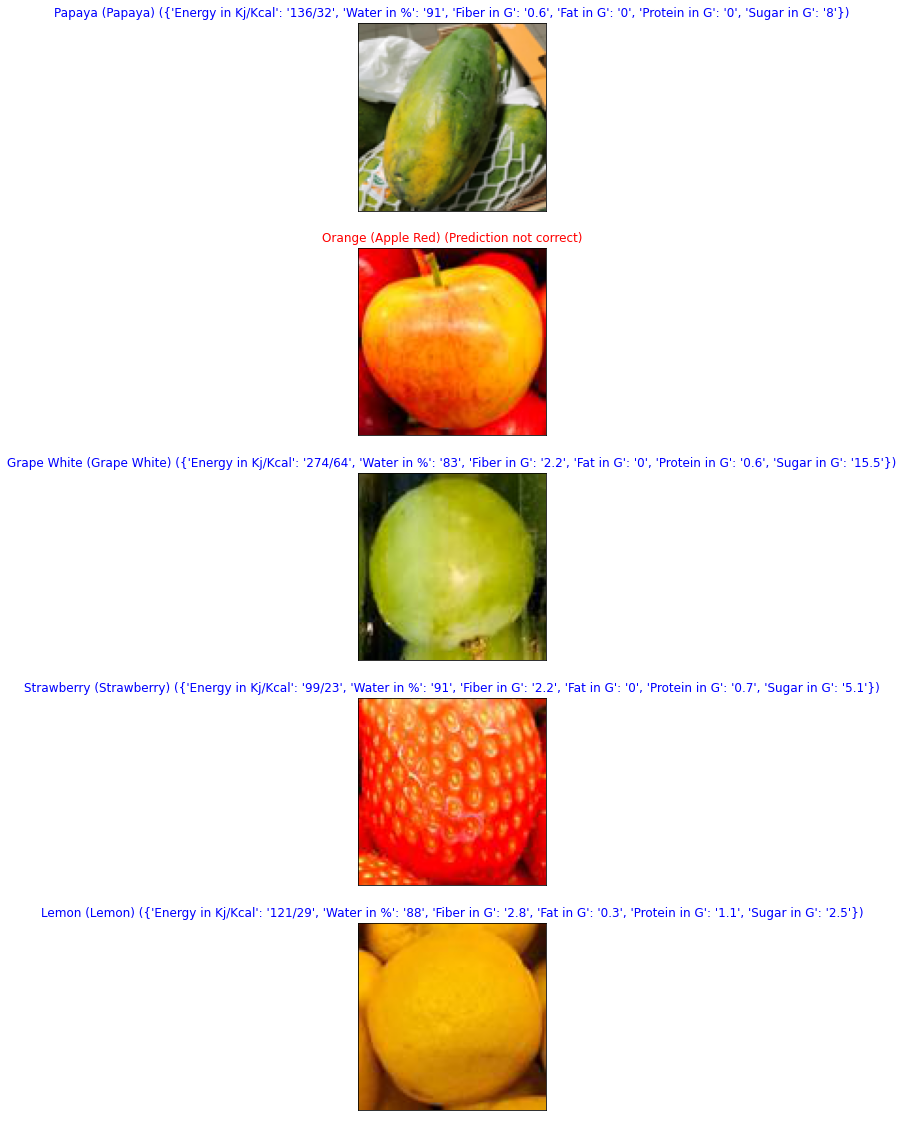

In [18]:
import csv
         
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=5, replace=False)):
    ax = fig.add_subplot(5, 1, i + 1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    
    x = target_labels[pred_idx]
    with open("nutrition.csv") as f:
        reader = csv.reader(f)
        for row in reader:
            if x in row[0]:
                nutrition_value = (row)
    val = {}
    val["Energy in Kj/Kcal"] = nutrition_value[1]
    val["Water in %"] = nutrition_value[2]
    val["Fiber in G"] = nutrition_value[3]
    val["Fat in G"] = nutrition_value[4]
    val["Protein in G"] = nutrition_value[5]
    val["Sugar in G"] = nutrition_value[6]
            
    if target_labels[pred_idx] != target_labels[true_idx]:
        val = "Prediction not correct"
    
    ax.set_title("{} ({}) ({})".format(target_labels[pred_idx], target_labels[true_idx] ,val ),
                 color=("blue" if pred_idx == true_idx else "red"))
    
    


## Let us plot training accuaracy vs validation accuracy

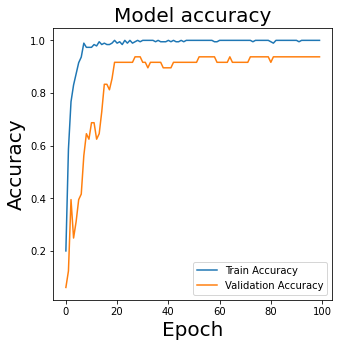

In [19]:
import matplotlib.pyplot as plt 
#plt.figure(1)  
fig = plt.figure(figsize=(5,5))   
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title('Model accuracy',fontsize=20)  
plt.ylabel('Accuracy',fontsize=20)  
plt.xlabel('Epoch',fontsize=20) 
plt.legend()
plt.show()


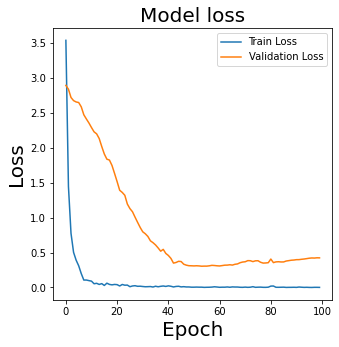

In [20]:
#plt.subplot(212)  
fig = plt.figure(figsize=(5,5)) 
plt.plot(history.history['loss'],label = "Train Loss")  
plt.plot(history.history['val_loss'],label = "Validation Loss")  
plt.title('Model loss',fontsize=20)  
plt.ylabel('Loss',fontsize=20)  
plt.xlabel('Epoch',fontsize=20)   
plt.legend()
plt.show()

## Check how many images are classified correctly 

In [21]:
import numpy as np

prob = model.predict(x_test)
pred = np.argmax(prob, axis = 1)
label = np.argmax(y_test,axis = 1) 

correct_indices = np.flatnonzero(pred == label) 
incorrect_indices = np.flatnonzero(pred != label) 
print(len(correct_indices)," classified correctly") 
print(len(incorrect_indices)," classified incorrectly")


150  classified correctly
9  classified incorrectly


## Let us plot the confusion matrix.

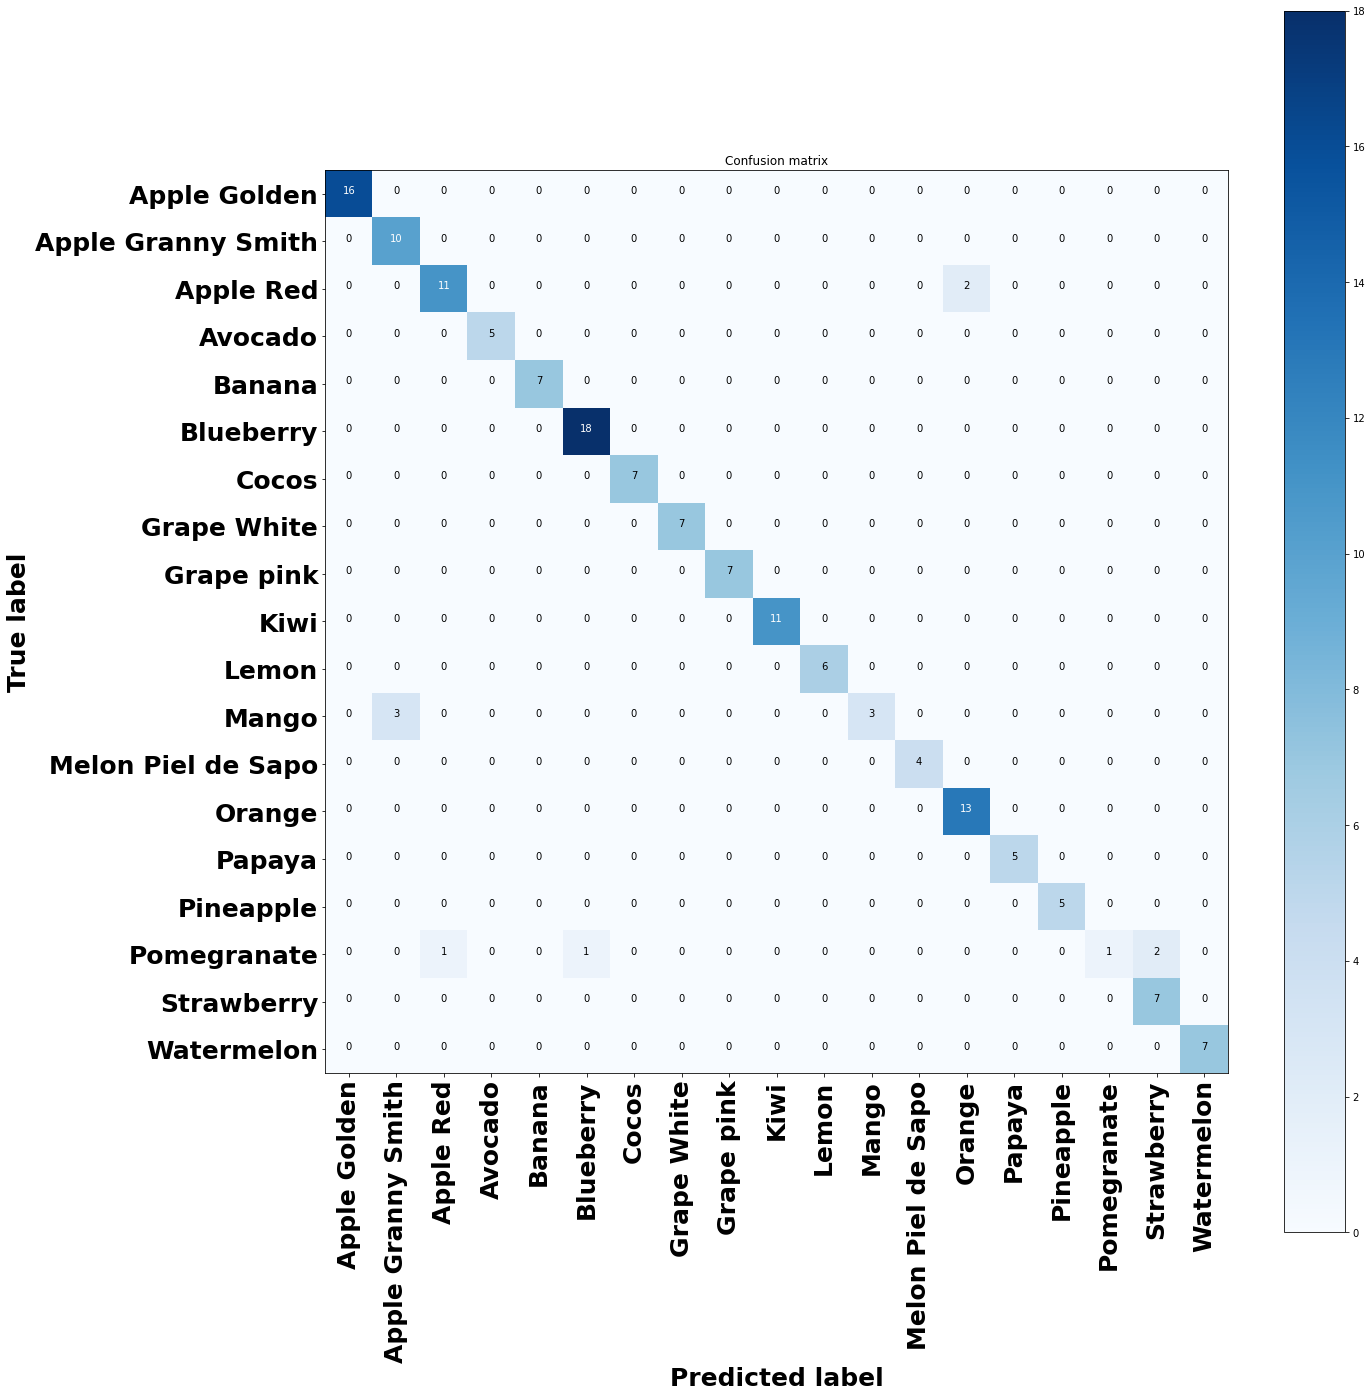

In [25]:


import itertools
fig = plt.figure(figsize=(20, 20))
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90, fontsize=25, weight = 'bold')
    plt.yticks(tick_marks, classes,fontsize=25, weight = 'bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=25, weight = 'bold')
    plt.xlabel('Predicted label',fontsize=25, weight = 'bold')

conf_mat = tf.math.confusion_matrix(labels=label, predictions=pred).numpy()
plot_confusion_matrix(conf_mat, target_labels)

# Plot the images that are classified incorrectly

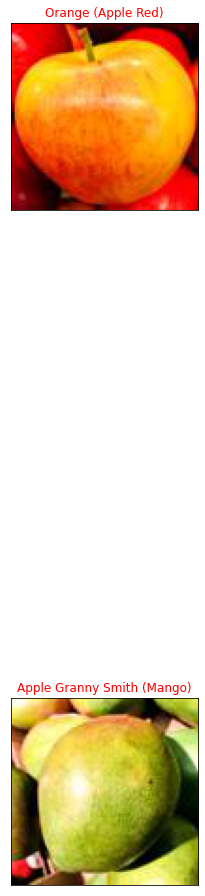

In [61]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(20, 20))

for i, idx in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
    #ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    
    if target_labels[pred_idx] != target_labels[true_idx]:
        ax = fig.add_subplot(5, 1, i + 1, xticks=[], yticks=[])
        
        ax.imshow(np.squeeze(x_test[idx]))
    
        
        #x = target_labels[pred_idx]
        ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx] ),
                 color=("red"))
   
    
    
